In [121]:
import numpy as np, itertools
import tools21cm as t2c, numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from PIL import Image
from scipy import special
from tqdm import tqdm
from ipywidgets import interact

import astropy.units as u
import astropy.constants as cst
from astropy.cosmology import Planck18 as cosmo

from scipy import stats

## Telescope layout
In a previous tutorial we mentioned that how we sample the fourier space will determine the accuracy and sensitivity of the resonstruction image observed (inverse Fourier transform).

In this tutorial we will see that the the layout of radio interferometer antennas, therfore, their baseline distribution, will determine how well we sample the Fourier space.

Here we look at layout of the SKA-Low telescope. The coordinates of the different station are generally give in the reference frame aligned with the Earth's rotational axis, often referred as $XYZ$-coordinate, in meter units.

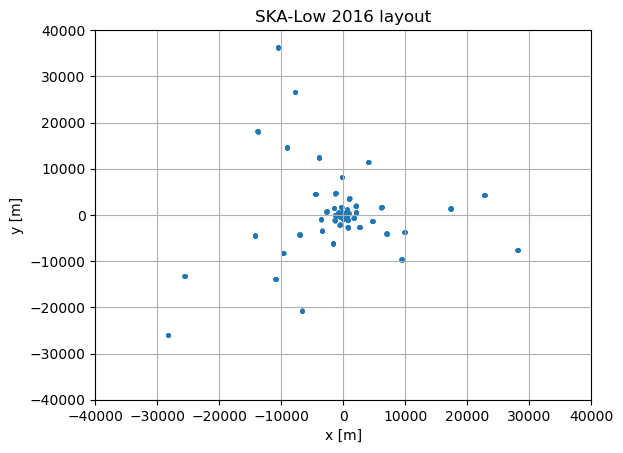

(None, None)

<Figure size 640x480 with 0 Axes>

In [80]:
layout = np.loadtxt('skalow_layout.txt') * u.m

plt.title('SKA-Low 2016 layout')
plt.scatter(layout[:,0], layout[:,1], s=5, color='tab:blue')
plt.grid(), plt.xlabel('x [m]'), plt.ylabel('y [m]')
plt.xlim(-40000, 40000), plt.ylim(-40000, 40000)
plt.show(), plt.clf()

## Number of baselines

The baselines, $ \vec{b} $, is the distance between a pair of stations/antennas (i.e., all possible antenna combinations). 

For a given number of stations/antennas, $N_{\rm ant}$, we can have a total of baselines:

$$N_B = \frac{N_{\rm ant}\cdot (N_{\rm ant} - 1)}{2} $$

In [81]:
N_ant = layout.shape[0]
N_B = int(N_ant*(N_ant-1)/2)

print('N_ant =', N_ant)
print('N_B =', N_B)

N_ant = 512
N_B = 130816


## The $uv$-coverage and coordinates

In the previous tutorials we mentioned as an interferometry telescope measures components of the sky Fourier Transform through the sampling of the Visibility function $V_{ij}$. Each pair of antennas (i.e.: baseline), $ \vec{b}_{ij} $, probes a particular Fourier mode of the sky signal. 

<img src="images/coords_baseline.png" alt="Drawing" style="width: 500px;"/>

This collection of samples is located in the ($u$, $v$, $w$) space and are often projected into a plane, the $uv$-plane, defined as:

$$  \frac{\vec{b}}{\lambda} = \frac{1}{\lambda}\begin{pmatrix}x \\ y \\ z \end{pmatrix} = \begin{pmatrix}u \\ v \\ w \end{pmatrix}$$
Remember that the baselines are differences of coordinates, i.e. for the distance pairs of antennas. The $uv$-coverage of an observation is a way to know which portion of the visibility function (frequency domain) is sampled.

At the same time the coordinate of a source in the sky is generally expreseed in Radial angle (RA), $\alpha$, in hour-angle unit, and declination (Dec), $\delta$, in degree unit. We can express the position of sources in the reference frame of the phase centre, $(\alpha_0,\, \delta_0)$, with the convertion to $l,m$ coordinate system, where:

* $l = \cos \delta \sin \Delta \alpha$
* $m = \sin \delta\cos\delta_0 -\cos \delta\sin\delta_0\cos\Delta \alpha$
* $\Delta \alpha = \alpha - \alpha_0$

## The $uv$-plane from a telescope layout
To obtain the corresponding $uv$-coordinates from the $XYZ$-coordinates (cartesian) of the antennas on Earth in radio interferometry, you need to calculate the baseline vectors between pairs of antennas. 

In [94]:
# define observed frequency and corresponding wavelenght
freq = 200*u.MHz
lam = (cst.c/freq).to('m')

# get pair of 
pair_comb = list(itertools.combinations(range(N_ant), 2))

assert np.shape(pair_comb)[0] == N_B

baselines = np.empty((N_B, layout.shape[1]))

for i in tqdm(range(N_B)):
    ii, jj = pair_comb[i]
    
    # calculate the distance between antennas
    uv = (layout[ii]-layout[jj])/lam
    baselines[i] = uv


100%|████████████████████████████████| 130816/130816 [00:02<00:00, 62532.05it/s]


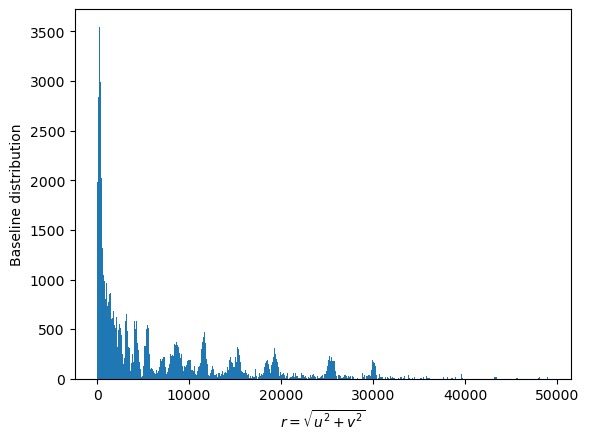

In [95]:
plt.hist(np.linalg.norm(baselines, axis=1), bins=1000);
plt.xlabel(r'$r = \sqrt{u^2 + v^2}$'), plt.ylabel('Baseline distribution');

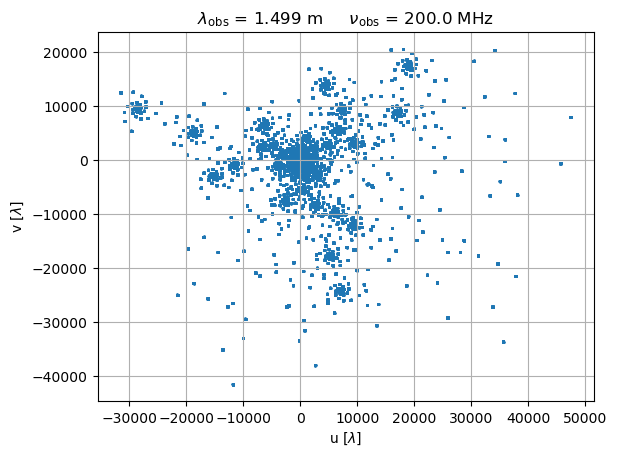

(None, None)

<Figure size 640x480 with 0 Axes>

In [96]:
# Plot the baselines in the uv-plane
plt.title(r'$\lambda_{\rm obs}$ = %.3f %s     $\nu_{\rm obs}$ = %.1f %s' %(lam.value, lam.unit, freq.value, freq.unit))
plt.scatter(baselines[:,0], baselines[:,1], s=1, color='tab:blue')
plt.grid(), plt.xlabel(r'u [$\lambda$]'), plt.ylabel(r'v [$\lambda$]')
plt.show(), plt.clf()

## Earth rotation & $uv$-coverage

The part of the baseline vector, $\vec{b}$, that metter is the $u$, $v$ component perpendicular with the phase center, $\hat{\vec{s}}_0$. Let remind that the phase center direction is a unit vector ans let's consider it has hour angle $ H_0$ (RA) as declination $ \delta_0 $ (Dec), i.e. $ \hat{\vec{s}}_0 = (H_0,\,\delta_0)$.

$$  \begin{pmatrix} u\\ v\\ w \end{pmatrix} = 
    \frac{1}{\lambda} 
       \begin{pmatrix} \sin H_0 & \cos H_0 & 0\\ 
                      -\sin \delta_0 \cos H_0 & \sin\delta_0\sin H_0 & \cos\delta_0\\
                       \cos \delta_0 \cos H_0 & -\cos\delta_0\sin H_0 & \sin\delta_0\\
        \end{pmatrix} 
        \begin{pmatrix} X\\ Y\\ Z \end{pmatrix} $$
        
Notice that the $uv$-coordinates depend on the hour angle, $H_0$, therefore the Earth roation will make the source, $ \hat{\vec{s}}$, and the phase centre, $ \hat{\vec{s}}_0$, move across the sky, thus the sampling a different coordinate in the $uv$-plane.

Making an observation over a long period of time is called __Earth Rotation Synthesis__ and it fills the $uv$-plane and allows for the telescope to achieve a better sensitivity.

In [154]:
# Observation parameters
freq = 1.420 * u.GHz                                     # Frequency
lambd = (cst.c/freq).to('m')                                      # Wavelength 
print(freq, lambd.cgs)

# Declination
dec = -30. * u.deg

# Time steps
time_steps = 200

# Radial angle, Hour angle window
h_angle = np.linspace(-2, 2, num=time_steps) * u.hourangle

t_obs = h_angle.max()-h_angle.min()
print('Observation length :', t_obs)
print('Integration time :', np.diff(h_angle)[0])
print('Number of time steps : ', time_steps)

1.42 GHz 21.112144929577468 cm
Observation length : 4.0 hourangle
Integration time : 0.0201005025125629 hourangle
Number of time steps :  200


In [104]:
# define ratation matrix
def Earth_Rotation_Effect(HA, delta):
    HA, delta = HA.to('rad'), delta.to('rad')
    
    return np.array([[np.sin(HA), np.cos(HA), 0], 
                     [-np.sin(delta)*np.cos(HA), np.sin(delta)*np.sin(HA), np.cos(delta)],
                     [np.cos(delta)*np.cos(HA), -np.cos(delta)*np.sin(HA), np.sin(delta)]])

In [146]:
UMAX, URES = 4000, 2
VMAX, VRES = 4000, 2
USIZE = int(UMAX / URES)
VSIZE = int(VMAX / VRES)

u_bin = np.linspace(-UMAX, UMAX, USIZE, endpoint=False)
v_bin = np.linspace(-VMAX, VMAX, VSIZE, endpoint=False)
uv_coverage = np.zeros((USIZE-1, VSIZE-1))

for i_t, h in enumerate(h_angle):
    rotation_matrix = Earth_Rotation_Effect(HA=h, delta=dec)
    rot_baseline = np.dot(rotation_matrix, baselines.T).T
    
    uv_coverage += stats.binned_statistic_2d(x=rot_baseline[:,0], y=rot_baseline[:,1], values=None, statistic='count', bins=[u_bin, v_bin]).statistic

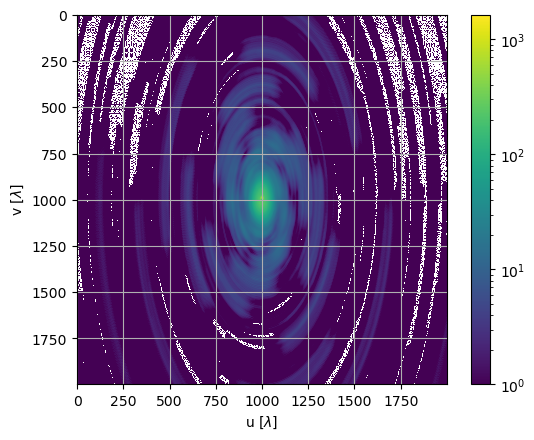

(None, None)

<Figure size 640x480 with 0 Axes>

In [147]:
plt.imshow(uv_coverage, norm=LogNorm())
plt.colorbar()
plt.grid(), plt.xlabel(r'u [$\lambda$]'), plt.ylabel(r'v [$\lambda$]')
plt.show(), plt.clf()